# [실습5] 금속분말 생성공정 최적화를 위한 딥러닝 심화


---

## 실습 목표
---
- 모델의 일반화에 대해 이해합니다.
- 일반화를 위한 방법들을 배워봅니다.
- 조기 종료 방법을 배워봅니다.
- 가중치 규제 방법을 배워봅니다.
- 앙상블 모델을 배워봅니다.
- 정규화를 배워봅니다.
- 데이터 증강 기법을 배워봅니다.

## 실습 목차
---
1. **일반화를 위한 방법들:** 일반화를 위한 여러 방법들을 사용해보고 성능을 비교합니다.

2. **조기 종료:** 조기 종료 방법을 수행해보고, 성능을 비교해봅니다,

3. **가중치 규제:** 가중치 규제 방법을 수행해보고, 성능을 비교해봅니다.

4. **앙상블 모델:** 앙상블 모델을 구현해봅니다.

5. **Dropout:** Dropout을 수행해보고, 성능을 비교해봅니다.

6. **정규화:** 정규화를 수행해보고, 성능을 비교해봅니다.

7. **데이터 증강 기법:** 데이터 증강기법을 수행해보고, 성능을 비교해봅니다.

## 실습 개요
---

이번 실습에서는 다양한 일반화를 위한 방법들을 수행해봅니다.

## 1. 일반화를 위한 방법들
---
금속분말 데이터셋을 이용하여 일반화 방법들을 수행해보겠습니다.


### 1.1 라이브러리 불러오기

In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
import json
import sklearn.metrics

2025-02-11 04:04:43.460016: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-11 04:04:43.572357: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-11 04:04:43.604160: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-11 04:04:44.840085: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

### 1.2 데이터셋 읽어오기

In [2]:
stage1 = {
    "train_X": np.load("./Data/train_data_stage1_X.npy"),
    "train_y": np.load("./Data/train_data_stage1_y.npy"),
    "valid_X": np.load("./Data/valid_data_stage1_X.npy"),
    "valid_y": np.load("./Data/valid_data_stage1_y.npy"),
    "test_X": np.load("./Data/test_data_stage1_X.npy"),
    "test_y": np.load("./Data/test_data_stage1_y.npy"),
}

stage2 = {
    "train_X": np.load("./Data/train_data_stage2_X.npy"),
    "train_y": np.load("./Data/train_data_stage2_y.npy"),
    "valid_X": np.load("./Data/valid_data_stage2_X.npy"),
    "valid_y": np.load("./Data/valid_data_stage2_y.npy"),
    "test_X": np.load("./Data/test_data_stage2_X.npy"),
    "test_y": np.load("./Data/test_data_stage2_y.npy"),
}

columns = json.load(open("./Data/valid_columns.json", "r"))

### 1.3 데이터 표준화하기

### 1.3.1 Stage1 데이터 표준화하기

In [3]:
stage1_X_mean = stage1["train_X"].mean(axis=0)
stage1_y_mean = stage1["train_y"].mean(axis=0)
print("입력값 평균:", stage1_X_mean)
print("출력값 평균:", stage1_y_mean)

입력값 평균: [  11.85294587  205.74478705  951.00255435 1242.437388     72.01273285
   72.01162996   70.34571071   11.07603585  408.95062376   81.47648118
   75.96962985   12.79330524  566.38390195  202.65058918   68.99620414
   69.10054828   73.3958155    13.89662164  226.12474952   76.81680896
   59.99898793    9.08815439  205.71384206  425.06943434  202.26546402
   78.00841235   78.00453278  345.11532917   13.26721071  246.73680272
   74.14375402   65.00868711  108.96768422   84.98831262   80.00354672
   15.32405834   23.84402174]
출력값 평균: [12.89768652 13.69662267  8.00480187 11.36113325 21.31940678 32.87843839
  0.12721732  1.34725458  1.09990652 19.8051213   7.68305334  1.4919701
  1.20588607  2.89104562 10.02515553]


In [4]:
stage1_X_std = stage1["train_X"].std(axis=0)
stage1_y_std = stage1["train_y"].std(axis=0)
print("입력값 표준편차:", stage1_X_std)
print("출력값 표준편차:", stage1_y_std)

입력값 표준편차: [5.10993143e-01 1.16806618e+01 1.27620111e+02 9.77321235e+01
 6.23396785e-02 4.06238919e-01 5.49867530e+00 6.36170724e-01
 2.05368437e+01 9.21642493e-01 2.06429784e+00 1.07360805e-01
 1.83380514e+01 1.48381842e+01 5.44970706e-02 1.06721153e-01
 3.94100055e-01 2.91335938e-02 3.06908107e+00 8.30358591e-01
 1.61971729e-01 3.95092636e-01 1.63223059e+01 9.53699574e+00
 1.58921785e+01 7.73526529e-02 1.14547773e-01 9.05396328e+00
 4.34061012e-01 6.10492128e+00 2.05042127e+00 6.27961350e-02
 5.59761035e+00 1.85637963e+01 1.18126539e-01 1.18770739e+00
 3.72221796e-01]
출력값 표준편차: [0.9270819  0.85503751 6.90580271 1.03664992 2.14313701 3.882343
 0.57606676 1.13060617 1.41265541 4.68687927 1.07824517 2.54294205
 0.66114934 0.92884134 7.38778856]


In [5]:
# 학습 데이터 표준화
stage1["train_X"] = (stage1["train_X"] - stage1_X_mean) / stage1_X_std
stage1["train_y"] = (stage1["train_y"] - stage1_y_mean) / stage1_y_std
# 검증용 데이터 표준화
stage1["valid_X"] = (stage1["valid_X"] - stage1_X_mean) / stage1_X_std
stage1["valid_y"] = (stage1["valid_y"] - stage1_y_mean) / stage1_y_std
# 테스트 데이터 표준화
stage1["test_X"] = (stage1["test_X"] - stage1_X_mean) / stage1_X_std
stage1["test_y"] = (stage1["test_y"] - stage1_y_mean) / stage1_y_std

### 1.3.2 Stage2 데이터 표준화하기

In [6]:
stage2_X_mean = stage2["train_X"].mean(axis=0)
stage2_y_mean = stage2["train_y"].mean(axis=0)
print("입력값 평균:", stage2_X_mean)
print("출력값 평균:", stage2_y_mean)

입력값 평균: [1.28976865e+01 1.36966227e+01 8.00480187e+00 1.13611333e+01
 2.13194068e+01 3.28784384e+01 1.27217323e-01 1.34725458e+00
 1.09990652e+00 1.98051213e+01 7.68305334e+00 1.49197010e+00
 1.20588607e+00 2.89104562e+00 1.00251555e+01 3.60122933e+02
 3.60136275e+02 1.72294333e+01 3.22627969e+02 3.09786854e+02
 1.87200947e+02 3.09998282e+02 2.89997582e+02 2.69681649e+02
 2.42661246e+02 2.44994629e+02 6.34195390e+01 1.54046742e+02
 1.53240583e+01 2.38440217e+01]
출력값 평균: [11.69212911  6.25614828 10.2499656  19.33555126  2.87697932  2.7475277
  0.53310706  2.91750962 18.38898671 11.61424043  7.53420311  3.54181714
  7.51699723]


In [7]:
stage2_X_std = stage2["train_X"].std(axis=0)
stage2_y_std = stage2["train_y"].std(axis=0)
print("입력값 표준편차:", stage2_X_std)
print("출력값 표준편차:", stage2_y_std)

입력값 표준편차: [ 0.9270819   0.85503751  6.90580271  1.03664992  2.14313701  3.882343
  0.57606676  1.13060617  1.41265541  4.68687927  1.07824517  2.54294205
  0.66114934  0.92884134  7.38778856  1.9209727   2.64895901  0.94209921
  3.61537985  2.74078134 23.41676809  0.03961971  0.05202987  1.01853204
  1.59098238  0.10771334  0.39587306  9.90869048  1.18770739  0.3722218 ]
출력값 표준편차: [3.62230517 1.60057596 2.30753588 4.62537631 9.09270122 0.37574164
 0.20467783 0.49744294 4.97294003 7.62127826 1.64901449 0.45450424
 2.0723342 ]


In [8]:
# 학습 데이터 표준화
stage2["train_X"] = (stage2["train_X"] - stage2_X_mean) / stage2_X_std
stage2["train_y"] = (stage2["train_y"] - stage2_y_mean) / stage2_y_std

# 검증용 데이터 표준화
stage2["valid_X"] = (stage2["valid_X"] - stage2_X_mean) / stage2_X_std
stage2["valid_y"] = (stage2["valid_y"] - stage2_y_mean) / stage2_y_std

# 테스트 데이터 표준화
stage2["test_X"] = (stage2["test_X"] - stage2_X_mean) / stage2_X_std
stage2["test_y"] = (stage2["test_y"] - stage2_y_mean) / stage2_y_std

### 1.4 학습 데이터 수에 따른 모델 성능 비교

In [9]:
data_use = [0.01, 0.1, 0.5, 1]

학습데이터의 1%, 10%, 50%, 100% 를 사용한 모델의 성능을 비교해보겠습니다.

In [10]:
for ratio in data_use:
    np.random.seed(0)
    random.seed(0)
    tf.random.set_seed(0)
    # 모델 정의
    MLP_model = tf.keras.Sequential(
        [
            Input(shape=stage1["train_X"].shape[1]),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dense(stage1["train_y"].shape[1]),
        ]
    )

    # 모델 컴파일
    MLP_model.compile(
        loss="mse",
        optimizer=tf.keras.optimizers.SGD(),
    )

    # 학습 데이터 개수
    total_data = len(stage1["train_X"])
    len_data = int(total_data * ratio)
    # 모델 학습
    history = MLP_model.fit(
        stage1["train_X"][:len_data],
        stage1["train_y"][:len_data],
        epochs=10 * int(1 / ratio),
        batch_size=16,
        verbose=0,
    )
    pred = MLP_model.predict(stage1["test_X"])
    r2 = sklearn.metrics.r2_score(stage1["test_y"], pred)
    print("R2 score (학습데이터 수: %d): %f" % (len_data, r2))

2025-02-11 04:04:49.998520: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-02-11 04:04:49.998571: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2025-02-11 04:04:49.998622: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ff1ac66610d6): /proc/driver/nvidia/version does not exist
2025-02-11 04:04:49.999115: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


36/36 [==============================] - 0s 2ms/step
R2 score (학습데이터 수: 90): 0.102912
36/36 [==============================] - 0s 2ms/step
R2 score (학습데이터 수: 901): 0.310822
36/36 [==============================] - 0s 1ms/step
R2 score (학습데이터 수: 4508): 0.344990
36/36 [==============================] - 0s 1ms/step
R2 score (학습데이터 수: 9016): 0.349326


학습데이터가 많을수록 모델의 성능이 좋은 것을 확인하였습니다.

## 2. Early stop
검증용 데이터를 이용하여 모델이 과적합 되기 전에 학습을 중지해보겠습니다.

### 2.1 모델 정의

In [11]:
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)
# MLP 모델을 설정합니다.
# early stop 을 하지 않을 모델입니다.
MLP_model = tf.keras.Sequential(
    [
        Input(shape=stage1["train_X"].shape[1]),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(stage1["train_y"].shape[1]),
    ]
)

# early stop 을 사용할 모델입니다.
MLP_model_es = tf.keras.Sequential(
    [
        Input(shape=stage1["train_X"].shape[1]),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(stage1["train_y"].shape[1]),
    ]
)

### 2.2 모델 학습 방법 설정

In [12]:
MLP_model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.SGD(),
)
MLP_model_es.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.SGD(),
)

### 2.3 모델 학습

먼저, early stop 을 사용하지 않을 모델부터 학습합니다. 실습시간을 고려하여 전체 학습데이터 중 1000개만 사용하겠습니다.

In [13]:
history = MLP_model.fit(
    stage1["train_X"][:1000],
    stage1["train_y"][:1000],
    validation_data=(stage1["valid_X"], stage1["valid_y"]),
    epochs=100,
    batch_size=16,
    verbose=2,
)

Epoch 1/100
63/63 - 1s - loss: 1.1507 - val_loss: 1.0349 - 772ms/epoch - 12ms/step
Epoch 2/100
63/63 - 0s - loss: 1.0744 - val_loss: 0.9810 - 236ms/epoch - 4ms/step
Epoch 3/100
63/63 - 0s - loss: 1.0332 - val_loss: 0.9454 - 243ms/epoch - 4ms/step
Epoch 4/100
63/63 - 0s - loss: 1.0035 - val_loss: 0.9184 - 213ms/epoch - 3ms/step
Epoch 5/100
63/63 - 0s - loss: 0.9804 - val_loss: 0.8975 - 261ms/epoch - 4ms/step
Epoch 6/100
63/63 - 0s - loss: 0.9617 - val_loss: 0.8800 - 238ms/epoch - 4ms/step
Epoch 7/100
63/63 - 0s - loss: 0.9463 - val_loss: 0.8665 - 245ms/epoch - 4ms/step
Epoch 8/100
63/63 - 0s - loss: 0.9335 - val_loss: 0.8546 - 242ms/epoch - 4ms/step
Epoch 9/100
63/63 - 0s - loss: 0.9221 - val_loss: 0.8442 - 244ms/epoch - 4ms/step
Epoch 10/100
63/63 - 0s - loss: 0.9117 - val_loss: 0.8359 - 232ms/epoch - 4ms/step
Epoch 11/100
63/63 - 0s - loss: 0.9025 - val_loss: 0.8293 - 215ms/epoch - 3ms/step
Epoch 12/100
63/63 - 0s - loss: 0.8938 - val_loss: 0.8221 - 251ms/epoch - 4ms/step
Epoch 13/100

Epoch 100/100
63/63 - 0s - loss: 0.3725 - val_loss: 0.6185 - 245ms/epoch - 4ms/step


다음으로, early stop을 사용할 모델을 학습합니다.

In [14]:
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=10)
history_es = MLP_model_es.fit(
    stage1["train_X"][:1000],
    stage1["train_y"][:1000],
    validation_data=(stage1["valid_X"], stage1["valid_y"]),
    epochs=100,
    batch_size=16,
    verbose=2,
    callbacks=[es],
)

Epoch 1/100
63/63 - 1s - loss: 1.1866 - val_loss: 1.0613 - 765ms/epoch - 12ms/step
Epoch 2/100
63/63 - 0s - loss: 1.0999 - val_loss: 1.0135 - 218ms/epoch - 3ms/step
Epoch 3/100
63/63 - 0s - loss: 1.0586 - val_loss: 0.9781 - 213ms/epoch - 3ms/step
Epoch 4/100
63/63 - 0s - loss: 1.0258 - val_loss: 0.9481 - 220ms/epoch - 3ms/step
Epoch 5/100
63/63 - 0s - loss: 0.9976 - val_loss: 0.9221 - 242ms/epoch - 4ms/step
Epoch 6/100
63/63 - 0s - loss: 0.9741 - val_loss: 0.9011 - 223ms/epoch - 4ms/step
Epoch 7/100
63/63 - 0s - loss: 0.9556 - val_loss: 0.8849 - 215ms/epoch - 3ms/step
Epoch 8/100
63/63 - 0s - loss: 0.9415 - val_loss: 0.8719 - 228ms/epoch - 4ms/step
Epoch 9/100
63/63 - 0s - loss: 0.9302 - val_loss: 0.8614 - 220ms/epoch - 3ms/step
Epoch 10/100
63/63 - 0s - loss: 0.9203 - val_loss: 0.8527 - 234ms/epoch - 4ms/step
Epoch 11/100
63/63 - 0s - loss: 0.9112 - val_loss: 0.8460 - 244ms/epoch - 4ms/step
Epoch 12/100
63/63 - 0s - loss: 0.9031 - val_loss: 0.8387 - 221ms/epoch - 4ms/step
Epoch 13/100

Epoch 100/100
63/63 - 0s - loss: 0.3760 - val_loss: 0.6153 - 226ms/epoch - 4ms/step


### 2.4 모델 예측 및 평가

In [15]:
pred = MLP_model.predict(stage1["test_X"])

36/36 [==============================] - 0s 2ms/step


In [16]:
r2 = sklearn.metrics.r2_score(stage1["test_y"], pred)
print("R2 score: %f" % r2)

R2 score: 0.360375


In [17]:
pred = MLP_model_es.predict(stage1["test_X"])

36/36 [==============================] - 0s 2ms/step


In [18]:
r2 = sklearn.metrics.r2_score(stage1["test_y"], pred)
print("R2 score: %f" % r2)

R2 score: 0.346507


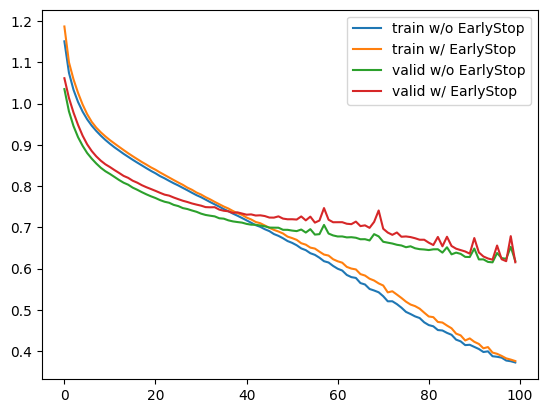

In [19]:
plt.plot(history.history["loss"], label="train w/o EarlyStop")
plt.plot(history_es.history["loss"], label="train w/ EarlyStop")
plt.plot(history.history["val_loss"], label="valid w/o EarlyStop")
plt.plot(history_es.history["val_loss"], label="valid w/ EarlyStop")
plt.legend()
plt.show()

Stage1 검증용 데이터셋을 이용하여 early stop 하였을 때는 모델의 성능이 오히려 더 낮습니다.

다만, 로그를 확인해보면 두 경우 모두 100 epoch 전부 학습이 완료되었고, 실제로는 Early stop이 발생하지 않았기 때문에 Early stop이 악영향을 미쳤다고 보기는 어렵습니다.

### [TODO] Stage2에 대해 Early stop 을 적용해봅니다.

In [20]:
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)
# MLP 모델을 설정합니다.
# early stop 을 하지 않을 모델입니다.
MLP_model = tf.keras.Sequential(
    [
        Input(shape=stage2["train_X"].shape[1]),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(stage2["train_y"].shape[1]),
    ]
)

# early stop 을 사용할 모델입니다.
MLP_model_es = tf.keras.Sequential(
    [
        Input(shape=stage2["train_X"].shape[1]),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(stage2["train_y"].shape[1]),
    ]
)

In [21]:
# MLP 모델을 컴파일 합니다.
MLP_model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.SGD(),
)
MLP_model_es.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.SGD(),
)

In [22]:
# Early stop 을 적용하지 않을 모델을 학습합니다.
history = MLP_model.fit(
    stage2["train_X"][:1000],
    stage2["train_y"][:1000],
    validation_data=(stage2["valid_X"], stage2["valid_y"]),
    epochs=100,
    batch_size=16,
    verbose=2,
)

Epoch 1/100
63/63 - 1s - loss: 0.9541 - val_loss: 1.0259 - 754ms/epoch - 12ms/step
Epoch 2/100
63/63 - 0s - loss: 0.8548 - val_loss: 0.9025 - 217ms/epoch - 3ms/step
Epoch 3/100
63/63 - 0s - loss: 0.7624 - val_loss: 0.7810 - 214ms/epoch - 3ms/step
Epoch 4/100
63/63 - 0s - loss: 0.6853 - val_loss: 0.7091 - 243ms/epoch - 4ms/step
Epoch 5/100
63/63 - 0s - loss: 0.6333 - val_loss: 0.6595 - 229ms/epoch - 4ms/step
Epoch 6/100
63/63 - 0s - loss: 0.6022 - val_loss: 0.6400 - 217ms/epoch - 3ms/step
Epoch 7/100
63/63 - 0s - loss: 0.5806 - val_loss: 0.6226 - 221ms/epoch - 4ms/step
Epoch 8/100
63/63 - 0s - loss: 0.5656 - val_loss: 0.6089 - 218ms/epoch - 3ms/step
Epoch 9/100
63/63 - 0s - loss: 0.5534 - val_loss: 0.5993 - 227ms/epoch - 4ms/step
Epoch 10/100
63/63 - 0s - loss: 0.5418 - val_loss: 0.5877 - 232ms/epoch - 4ms/step
Epoch 11/100
63/63 - 0s - loss: 0.5330 - val_loss: 0.5843 - 222ms/epoch - 4ms/step
Epoch 12/100
63/63 - 0s - loss: 0.5254 - val_loss: 0.5745 - 265ms/epoch - 4ms/step
Epoch 13/100

Epoch 100/100
63/63 - 0s - loss: 0.3751 - val_loss: 0.4693 - 241ms/epoch - 4ms/step


In [23]:
# 다음으로, Early stop 을 적용할 모델을 학습합니다.

es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=10)
history_es = MLP_model_es.fit(
    stage2["train_X"][:1000],
    stage2["train_y"][:1000],
    validation_data=(stage2["valid_X"], stage2["valid_y"]),
    epochs=100,
    batch_size=16,
    verbose=2,
    callbacks=[es],
)

Epoch 1/100
63/63 - 1s - loss: 0.9788 - val_loss: 1.0196 - 757ms/epoch - 12ms/step
Epoch 2/100
63/63 - 0s - loss: 0.8233 - val_loss: 0.8521 - 227ms/epoch - 4ms/step
Epoch 3/100
63/63 - 0s - loss: 0.7090 - val_loss: 0.7288 - 210ms/epoch - 3ms/step
Epoch 4/100
63/63 - 0s - loss: 0.6431 - val_loss: 0.6751 - 245ms/epoch - 4ms/step
Epoch 5/100
63/63 - 0s - loss: 0.6066 - val_loss: 0.6382 - 276ms/epoch - 4ms/step
Epoch 6/100
63/63 - 0s - loss: 0.5849 - val_loss: 0.6227 - 268ms/epoch - 4ms/step
Epoch 7/100
63/63 - 0s - loss: 0.5685 - val_loss: 0.6095 - 230ms/epoch - 4ms/step
Epoch 8/100
63/63 - 0s - loss: 0.5552 - val_loss: 0.5982 - 240ms/epoch - 4ms/step
Epoch 9/100
63/63 - 0s - loss: 0.5448 - val_loss: 0.5902 - 219ms/epoch - 3ms/step
Epoch 10/100
63/63 - 0s - loss: 0.5340 - val_loss: 0.5820 - 238ms/epoch - 4ms/step
Epoch 11/100
63/63 - 0s - loss: 0.5260 - val_loss: 0.5725 - 230ms/epoch - 4ms/step
Epoch 12/100
63/63 - 0s - loss: 0.5186 - val_loss: 0.5680 - 237ms/epoch - 4ms/step
Epoch 13/100

Epoch 100/100
63/63 - 0s - loss: 0.3727 - val_loss: 0.4667 - 167ms/epoch - 3ms/step


In [24]:
# Early stop 을 사용하지 않은 모델을 평가합니다.
pred = MLP_model.predict(stage2["test_X"])
r2 = sklearn.metrics.r2_score(stage2["test_y"], pred)
print("R2 score: %f" % r2)

36/36 [==============================] - 0s 1ms/step
R2 score: 0.517047


In [25]:
# Early stop 을 사용한 모델을 평가합니다.
pred = MLP_model_es.predict(stage2['test_X'])
r2 = sklearn.metrics.r2_score(stage2["test_y"], pred)
print("R2 score: %f" % r2)

36/36 [==============================] - 0s 1ms/step
R2 score: 0.530186


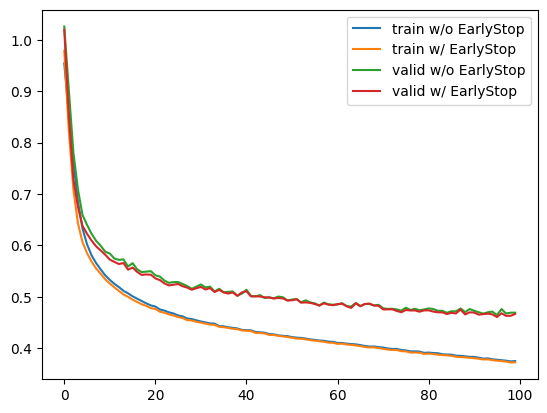

In [26]:
plt.plot(history.history["loss"], label="train w/o EarlyStop")
plt.plot(history_es.history["loss"], label="train w/ EarlyStop")
plt.plot(history.history["val_loss"], label="valid w/o EarlyStop")
plt.plot(history_es.history["val_loss"], label="valid w/ EarlyStop")
plt.legend()
plt.show()

Stage2 의 데이터에 대해서는 early stop을 사용하였을 때, r2-score 가 더 높은 것을 확인할 수 있습니다.

다만, 이번에도 로그를 확인해보면 두 경우 모두 100 epoch 전부 학습이 완료되었기 때문에 Early stop이 큰 영향을 미쳤다고 보기는 어렵습니다.

## 3. 가중치 규제
---
금속분말 데이터셋을 이용하여 가중치 규제를 모델에 적용해보겠습니다.


### 3.1 모델 정의

In [27]:
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)
# MLP 모델을 설정합니다.
# 가중치 규제를 하지 않을 모델입니다.
MLP_model = tf.keras.Sequential(
    [
        Input(shape=stage1["train_X"].shape[1]),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(stage1["train_y"].shape[1]),
    ]
)

# 가중치규제를 사용할 모델입니다. L1 regularizer을 적용해봅니다.
MLP_model_reg = tf.keras.Sequential(
    [
        Input(shape=stage1["train_X"].shape[1]),
        tf.keras.layers.Dense(
            128, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.001)
        ),
        tf.keras.layers.Dense(
            64, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.001)
        ),
        tf.keras.layers.Dense(
            32, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.001)
        ),
        tf.keras.layers.Dense(stage1["train_y"].shape[1]),
    ]
)

### 3.2 모델 학습 방법 설정

In [28]:
MLP_model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.SGD(),
)
MLP_model_reg.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.SGD(),
)

### 3.3 모델 학습

In [29]:
history = MLP_model.fit(
    stage1["train_X"][:1000],
    stage1["train_y"][:1000],
    validation_data=(stage1["valid_X"], stage1["valid_y"]),
    epochs=100,
    batch_size=16,
    verbose=2,
)

Epoch 1/100
63/63 - 1s - loss: 1.1507 - val_loss: 1.0349 - 596ms/epoch - 9ms/step
Epoch 2/100
63/63 - 0s - loss: 1.0744 - val_loss: 0.9810 - 170ms/epoch - 3ms/step
Epoch 3/100
63/63 - 0s - loss: 1.0332 - val_loss: 0.9454 - 176ms/epoch - 3ms/step
Epoch 4/100
63/63 - 0s - loss: 1.0035 - val_loss: 0.9184 - 171ms/epoch - 3ms/step
Epoch 5/100
63/63 - 0s - loss: 0.9804 - val_loss: 0.8975 - 181ms/epoch - 3ms/step
Epoch 6/100
63/63 - 0s - loss: 0.9617 - val_loss: 0.8800 - 174ms/epoch - 3ms/step
Epoch 7/100
63/63 - 0s - loss: 0.9463 - val_loss: 0.8665 - 221ms/epoch - 4ms/step
Epoch 8/100
63/63 - 0s - loss: 0.9335 - val_loss: 0.8546 - 218ms/epoch - 3ms/step
Epoch 9/100
63/63 - 0s - loss: 0.9221 - val_loss: 0.8442 - 256ms/epoch - 4ms/step
Epoch 10/100
63/63 - 0s - loss: 0.9117 - val_loss: 0.8359 - 246ms/epoch - 4ms/step
Epoch 11/100
63/63 - 0s - loss: 0.9025 - val_loss: 0.8293 - 255ms/epoch - 4ms/step
Epoch 12/100
63/63 - 0s - loss: 0.8938 - val_loss: 0.8221 - 200ms/epoch - 3ms/step
Epoch 13/100


Epoch 100/100
63/63 - 0s - loss: 0.3725 - val_loss: 0.6185 - 262ms/epoch - 4ms/step


In [30]:
history_reg = MLP_model_reg.fit(
    stage1["train_X"][:1000],
    stage1["train_y"][:1000],
    validation_data=(stage1["valid_X"], stage1["valid_y"]),
    epochs=100,
    batch_size=16,
    verbose=2,
)

Epoch 1/100
63/63 - 1s - loss: 1.3714 - val_loss: 1.2456 - 857ms/epoch - 14ms/step
Epoch 2/100
63/63 - 0s - loss: 1.2840 - val_loss: 1.1974 - 235ms/epoch - 4ms/step
Epoch 3/100
63/63 - 0s - loss: 1.2425 - val_loss: 1.1618 - 219ms/epoch - 3ms/step
Epoch 4/100
63/63 - 0s - loss: 1.2095 - val_loss: 1.1317 - 297ms/epoch - 5ms/step
Epoch 5/100
63/63 - 0s - loss: 1.1813 - val_loss: 1.1056 - 240ms/epoch - 4ms/step
Epoch 6/100
63/63 - 0s - loss: 1.1576 - val_loss: 1.0843 - 260ms/epoch - 4ms/step
Epoch 7/100
63/63 - 0s - loss: 1.1388 - val_loss: 1.0677 - 239ms/epoch - 4ms/step
Epoch 8/100
63/63 - 0s - loss: 1.1243 - val_loss: 1.0544 - 253ms/epoch - 4ms/step
Epoch 9/100
63/63 - 0s - loss: 1.1125 - val_loss: 1.0432 - 251ms/epoch - 4ms/step
Epoch 10/100
63/63 - 0s - loss: 1.1023 - val_loss: 1.0342 - 239ms/epoch - 4ms/step
Epoch 11/100
63/63 - 0s - loss: 1.0931 - val_loss: 1.0274 - 229ms/epoch - 4ms/step
Epoch 12/100
63/63 - 0s - loss: 1.0848 - val_loss: 1.0198 - 226ms/epoch - 4ms/step
Epoch 13/100

Epoch 100/100
63/63 - 0s - loss: 0.5822 - val_loss: 0.7938 - 228ms/epoch - 4ms/step


In [31]:
pred = MLP_model.predict(stage1["test_X"])

36/36 [==============================] - 0s 2ms/step


In [32]:
r2 = sklearn.metrics.r2_score(stage1["test_y"], pred)
print("R2 score: %f" % r2)

R2 score: 0.360375


In [33]:
pred = MLP_model_reg.predict(stage1["test_X"])

36/36 [==============================] - 0s 1ms/step


In [34]:
r2 = sklearn.metrics.r2_score(stage1["test_y"], pred)
print("R2 score: %f" % r2)

R2 score: 0.354616


가중치 규제를 사용한 모델에서 성능이 더 좋았습니다.

### [TODO] Stage2에 대해 가중치규제를 적용해봅니다.

In [35]:
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)
# MLP 모델을 설정합니다.
# 가중치 규제를 하지 않을 모델입니다.
MLP_model = tf.keras.Sequential([
    Input(shape = stage2['train_X'].shape[1]),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(stage2['train_y'].shape[1])
])

# 가중치규제를 사용할 모델입니다. L1 regularizer을 적용해봅니다.
MLP_model_reg = tf.keras.Sequential(
    [
        Input(shape=stage2["train_X"].shape[1]),
        tf.keras.layers.Dense(
            128, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.001)
        ),
        tf.keras.layers.Dense(
            64, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.001)
        ),
        tf.keras.layers.Dense(
            32, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.001)
        ),
        tf.keras.layers.Dense(stage2["train_y"].shape[1]),
    ]
)

In [36]:
# MLP 모델을 컴파일 합니다.
MLP_model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.SGD(),
)
MLP_model_reg.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.SGD(),
)

In [37]:
# 가중치규제를 사용하지 않는 모델을 학습합니다.
history = MLP_model.fit(
    stage2["train_X"][:1000],
    stage2["train_y"][:1000],
    validation_data=(stage2["valid_X"], stage2["valid_y"]),
    epochs=100,
    batch_size=16,
    verbose=2,
)

Epoch 1/100
63/63 - 1s - loss: 0.9541 - val_loss: 1.0259 - 761ms/epoch - 12ms/step
Epoch 2/100
63/63 - 0s - loss: 0.8548 - val_loss: 0.9025 - 222ms/epoch - 4ms/step
Epoch 3/100
63/63 - 0s - loss: 0.7624 - val_loss: 0.7810 - 230ms/epoch - 4ms/step
Epoch 4/100
63/63 - 0s - loss: 0.6853 - val_loss: 0.7091 - 232ms/epoch - 4ms/step
Epoch 5/100
63/63 - 0s - loss: 0.6333 - val_loss: 0.6595 - 212ms/epoch - 3ms/step
Epoch 6/100
63/63 - 0s - loss: 0.6022 - val_loss: 0.6400 - 206ms/epoch - 3ms/step
Epoch 7/100
63/63 - 0s - loss: 0.5806 - val_loss: 0.6226 - 225ms/epoch - 4ms/step
Epoch 8/100
63/63 - 0s - loss: 0.5656 - val_loss: 0.6089 - 240ms/epoch - 4ms/step
Epoch 9/100
63/63 - 0s - loss: 0.5534 - val_loss: 0.5993 - 246ms/epoch - 4ms/step
Epoch 10/100
63/63 - 0s - loss: 0.5418 - val_loss: 0.5877 - 236ms/epoch - 4ms/step
Epoch 11/100
63/63 - 0s - loss: 0.5330 - val_loss: 0.5843 - 289ms/epoch - 5ms/step
Epoch 12/100
63/63 - 0s - loss: 0.5254 - val_loss: 0.5745 - 295ms/epoch - 5ms/step
Epoch 13/100

Epoch 100/100
63/63 - 0s - loss: 0.3751 - val_loss: 0.4693 - 168ms/epoch - 3ms/step


In [38]:
# 다음으로, 가중치규제를 사용하는 모델을 학습합니다.
history_reg = MLP_model_reg.fit(
    stage2["train_X"][:1000],
    stage2["train_y"][:1000],
    validation_data=(stage2["valid_X"], stage2["valid_y"]),
    epochs=100,
    batch_size=16,
    verbose=2,
)

Epoch 1/100
63/63 - 1s - loss: 1.1552 - val_loss: 1.1960 - 710ms/epoch - 11ms/step
Epoch 2/100
63/63 - 0s - loss: 0.9997 - val_loss: 1.0291 - 191ms/epoch - 3ms/step
Epoch 3/100
63/63 - 0s - loss: 0.8856 - val_loss: 0.9057 - 166ms/epoch - 3ms/step
Epoch 4/100
63/63 - 0s - loss: 0.8194 - val_loss: 0.8516 - 163ms/epoch - 3ms/step
Epoch 5/100
63/63 - 0s - loss: 0.7827 - val_loss: 0.8144 - 212ms/epoch - 3ms/step
Epoch 6/100
63/63 - 0s - loss: 0.7607 - val_loss: 0.7982 - 222ms/epoch - 4ms/step
Epoch 7/100
63/63 - 0s - loss: 0.7441 - val_loss: 0.7849 - 210ms/epoch - 3ms/step
Epoch 8/100
63/63 - 0s - loss: 0.7306 - val_loss: 0.7739 - 257ms/epoch - 4ms/step
Epoch 9/100
63/63 - 0s - loss: 0.7201 - val_loss: 0.7655 - 258ms/epoch - 4ms/step
Epoch 10/100
63/63 - 0s - loss: 0.7090 - val_loss: 0.7569 - 236ms/epoch - 4ms/step
Epoch 11/100
63/63 - 0s - loss: 0.7007 - val_loss: 0.7472 - 261ms/epoch - 4ms/step
Epoch 12/100
63/63 - 0s - loss: 0.6932 - val_loss: 0.7418 - 240ms/epoch - 4ms/step
Epoch 13/100

Epoch 100/100
63/63 - 0s - loss: 0.5343 - val_loss: 0.6224 - 169ms/epoch - 3ms/step


In [39]:
# 가중치 규제를 사용하지 않은 모델을 평가합니다.
pred = MLP_model.predict(stage2["test_X"])
r2 = sklearn.metrics.r2_score(stage2["test_y"], pred)
print("R2 score: %f" % r2)

36/36 [==============================] - 0s 1ms/step
R2 score: 0.517047


In [40]:
pred = MLP_model_reg.predict(stage2["test_X"])
r2 = sklearn.metrics.r2_score(stage2["test_y"], pred)
print("R2 score: %f" % r2)

36/36 [==============================] - 0s 1ms/step
R2 score: 0.526078


## 4. 앙상블 모델
---
금속분말 데이터셋을 이용하여 앙상블 모델을 학습해보겠습니다.


### 4.1 Weak 모델 정의

In [41]:
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)
n_estimators = 10
models = []
for i in range(n_estimators):
    model = tf.keras.Sequential(
        [
            Input(shape=stage1["train_X"].shape[1]),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dense(16, activation="relu"),
            tf.keras.layers.Dense(stage1["train_y"].shape[1]),
        ]
    )
    models.append(model)

### 4.2 모델 컴파일

In [42]:
for model in models:
    model.compile(
        loss="mse",
        optimizer=tf.keras.optimizers.Adam(),
    )

### 4.3 모델 학습

In [43]:
len_training_data = len(stage1["train_X"])
len_subset = int(len_training_data * 0.25)
histories = []
idxs = np.arange(len_training_data)
for model in models:
    train_X = stage1["train_X"][idxs][:len_subset]
    train_y = stage1["train_y"][idxs][:len_subset]
    history = model.fit(train_X, train_y, epochs=10, batch_size=16, verbose=2)
    histories.append(history)
    np.random.shuffle(idxs)

Epoch 1/10
141/141 - 1s - loss: 0.9907 - 547ms/epoch - 4ms/step
Epoch 2/10
141/141 - 0s - loss: 0.8617 - 190ms/epoch - 1ms/step
Epoch 3/10
141/141 - 0s - loss: 0.8131 - 191ms/epoch - 1ms/step
Epoch 4/10
141/141 - 0s - loss: 0.7860 - 179ms/epoch - 1ms/step
Epoch 5/10
141/141 - 0s - loss: 0.7647 - 176ms/epoch - 1ms/step
Epoch 6/10
141/141 - 0s - loss: 0.7446 - 183ms/epoch - 1ms/step
Epoch 7/10
141/141 - 0s - loss: 0.7284 - 180ms/epoch - 1ms/step
Epoch 8/10
141/141 - 0s - loss: 0.7172 - 179ms/epoch - 1ms/step
Epoch 9/10
141/141 - 0s - loss: 0.7057 - 192ms/epoch - 1ms/step
Epoch 10/10
141/141 - 0s - loss: 0.6959 - 185ms/epoch - 1ms/step
Epoch 1/10
141/141 - 1s - loss: 0.8878 - 556ms/epoch - 4ms/step
Epoch 2/10
141/141 - 0s - loss: 0.7062 - 220ms/epoch - 2ms/step
Epoch 3/10
141/141 - 0s - loss: 0.6524 - 232ms/epoch - 2ms/step
Epoch 4/10
141/141 - 0s - loss: 0.6262 - 218ms/epoch - 2ms/step
Epoch 5/10
141/141 - 0s - loss: 0.6044 - 203ms/epoch - 1ms/step
Epoch 6/10
141/141 - 0s - loss: 0.5875 

### 4.4 모델 예측 및 평가

In [44]:
preds = 0
for i, model in enumerate(models):
    pred = model.predict(stage1["test_X"])
    r2 = sklearn.metrics.r2_score(stage1["test_y"], pred)
    print("%d 번째 weak model - R2 score: %f" % (i + 1, r2))
    preds += pred
preds /= len(models)
r2 = sklearn.metrics.r2_score(stage1["test_y"], preds)
print("앙상블 모델 R2 score: %f" % r2)

36/36 [==============================] - 0s 2ms/step
1 번째 weak model - R2 score: 0.364301
36/36 [==============================] - 0s 1ms/step
2 번째 weak model - R2 score: 0.352849
36/36 [==============================] - 0s 1ms/step
3 번째 weak model - R2 score: 0.352064
36/36 [==============================] - 0s 2ms/step
4 번째 weak model - R2 score: 0.356870
36/36 [==============================] - 0s 1ms/step
5 번째 weak model - R2 score: 0.373838
36/36 [==============================] - 0s 1ms/step
6 번째 weak model - R2 score: 0.359003
36/36 [==============================] - 0s 1ms/step
7 번째 weak model - R2 score: 0.354602
36/36 [==============================] - 0s 1ms/step
8 번째 weak model - R2 score: 0.337947
36/36 [==============================] - 0s 1ms/step
9 번째 weak model - R2 score: 0.365411
36/36 [==============================] - 0s 1ms/step
10 번째 weak model - R2 score: 0.355624
앙상블 모델 R2 score: 0.384129


앙상블 모델이 각각의 약한 모델보다 성능이 좋은 것을 확인할 수 있습니다.

### [TODO] Stage2에 대해 앙상블을 적용해봅니다.

In [45]:
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)
# Weak 모델 정의
n_estimators = 10
models = []
# Stage1 에 사용했던 앙상블 모델을 그대로 사용해봅시다.
for i in range(n_estimators):
    model = tf.keras.Sequential(
        [
            Input(shape=stage2["train_X"].shape[1]),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dense(16, activation="relu"),
            tf.keras.layers.Dense(stage2["train_y"].shape[1]),
        ]
    )
    models.append(model)

In [46]:
# 모델 컴파일
for model in models:
    model.compile(
        loss="mse",
        optimizer=tf.keras.optimizers.Adam(),
    )

In [47]:
# 모델 학습
len_training_data = len(stage2["train_X"])
len_subset = int(len_training_data * 0.25)
histories = []
idxs = np.arange(len_training_data)
for model in models:
    train_X = stage2["train_X"][idxs][:len_subset]
    train_y = stage2["train_y"][idxs][:len_subset]
    history = model.fit(train_X, train_y, epochs=10, batch_size=16, verbose=2)
    histories.append(history)
    np.random.shuffle(idxs)

Epoch 1/10
141/141 - 1s - loss: 0.8963 - 730ms/epoch - 5ms/step
Epoch 2/10
141/141 - 0s - loss: 0.6301 - 271ms/epoch - 2ms/step
Epoch 3/10
141/141 - 0s - loss: 0.5504 - 293ms/epoch - 2ms/step
Epoch 4/10
141/141 - 0s - loss: 0.5187 - 284ms/epoch - 2ms/step
Epoch 5/10
141/141 - 0s - loss: 0.5032 - 289ms/epoch - 2ms/step
Epoch 6/10
141/141 - 0s - loss: 0.4926 - 267ms/epoch - 2ms/step
Epoch 7/10
141/141 - 0s - loss: 0.4813 - 287ms/epoch - 2ms/step
Epoch 8/10
141/141 - 0s - loss: 0.4741 - 264ms/epoch - 2ms/step
Epoch 9/10
141/141 - 0s - loss: 0.4684 - 276ms/epoch - 2ms/step
Epoch 10/10
141/141 - 0s - loss: 0.4601 - 346ms/epoch - 2ms/step
Epoch 1/10
141/141 - 1s - loss: 0.9700 - 730ms/epoch - 5ms/step
Epoch 2/10
141/141 - 0s - loss: 0.6853 - 296ms/epoch - 2ms/step
Epoch 3/10
141/141 - 0s - loss: 0.6060 - 285ms/epoch - 2ms/step
Epoch 4/10
141/141 - 0s - loss: 0.5701 - 340ms/epoch - 2ms/step
Epoch 5/10
141/141 - 0s - loss: 0.5492 - 327ms/epoch - 2ms/step
Epoch 6/10
141/141 - 0s - loss: 0.5341 

In [48]:
# 모델 예측 및 평가
preds = 0
for i, model in enumerate(models):
    pred = model.predict(stage2["test_X"])
    r2 = sklearn.metrics.r2_score(stage2["test_y"], pred)
    print("%d 번째 weak model - R2 score: %f" % (i + 1, r2))
    preds += pred
preds /= len(models)
r2 = sklearn.metrics.r2_score(stage2["test_y"], preds)
print("앙상블 모델 R2 score: %f" % r2)

36/36 [==============================] - 0s 1ms/step
1 번째 weak model - R2 score: 0.528430
36/36 [==============================] - 0s 2ms/step
2 번째 weak model - R2 score: 0.547278
36/36 [==============================] - 0s 1ms/step
3 번째 weak model - R2 score: 0.541820
36/36 [==============================] - 0s 1ms/step
4 번째 weak model - R2 score: 0.533642
36/36 [==============================] - 0s 1ms/step
5 번째 weak model - R2 score: 0.537208
36/36 [==============================] - 0s 1ms/step
6 번째 weak model - R2 score: 0.537491
36/36 [==============================] - 0s 1ms/step
7 번째 weak model - R2 score: 0.542404
36/36 [==============================] - 0s 1ms/step
8 번째 weak model - R2 score: 0.517011
36/36 [==============================] - 0s 1ms/step
9 번째 weak model - R2 score: 0.556370
36/36 [==============================] - 0s 1ms/step
10 번째 weak model - R2 score: 0.518245
앙상블 모델 R2 score: 0.565864


## 5. Dropout
---
금속분말 데이터셋을 이용하여 Dropout 을 적용해보겠습니다.


### 5.1 모델 정의

In [49]:
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)
# MLP 모델을 설정합니다.
# Dropout을 하지 않을 모델입니다.
MLP_model = tf.keras.Sequential(
    [
        Input(shape=stage1["train_X"].shape[1]),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(stage1["train_y"].shape[1]),
    ]
)

# Dropout을 사용할 모델입니다. rate는 0.2로 설정합니다.
MLP_model_dropout = tf.keras.Sequential(
    [
        Input(shape=stage1["train_X"].shape[1]),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Dense(stage1["train_y"].shape[1]),
    ]
)

### 5.2 모델 컴파일

In [50]:
MLP_model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.SGD(),
)
MLP_model_dropout.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.SGD(),
)

### 5.3 모델 학습

In [51]:
history = MLP_model.fit(
    stage1["train_X"][:1000],
    stage1["train_y"][:1000],
    validation_data=(stage1["valid_X"], stage1["valid_y"]),
    epochs=100,
    batch_size=16,
    verbose=2,
)

Epoch 1/100
63/63 - 1s - loss: 1.1507 - val_loss: 1.0349 - 743ms/epoch - 12ms/step
Epoch 2/100
63/63 - 0s - loss: 1.0744 - val_loss: 0.9810 - 245ms/epoch - 4ms/step
Epoch 3/100
63/63 - 0s - loss: 1.0332 - val_loss: 0.9454 - 211ms/epoch - 3ms/step
Epoch 4/100
63/63 - 0s - loss: 1.0035 - val_loss: 0.9184 - 175ms/epoch - 3ms/step
Epoch 5/100
63/63 - 0s - loss: 0.9804 - val_loss: 0.8975 - 212ms/epoch - 3ms/step
Epoch 6/100
63/63 - 0s - loss: 0.9617 - val_loss: 0.8800 - 245ms/epoch - 4ms/step
Epoch 7/100
63/63 - 0s - loss: 0.9463 - val_loss: 0.8665 - 267ms/epoch - 4ms/step
Epoch 8/100
63/63 - 0s - loss: 0.9335 - val_loss: 0.8546 - 288ms/epoch - 5ms/step
Epoch 9/100
63/63 - 0s - loss: 0.9221 - val_loss: 0.8442 - 237ms/epoch - 4ms/step
Epoch 10/100
63/63 - 0s - loss: 0.9117 - val_loss: 0.8359 - 231ms/epoch - 4ms/step
Epoch 11/100
63/63 - 0s - loss: 0.9025 - val_loss: 0.8293 - 240ms/epoch - 4ms/step
Epoch 12/100
63/63 - 0s - loss: 0.8938 - val_loss: 0.8221 - 238ms/epoch - 4ms/step
Epoch 13/100

Epoch 100/100
63/63 - 0s - loss: 0.3725 - val_loss: 0.6185 - 251ms/epoch - 4ms/step


In [52]:
history_dropout = MLP_model_dropout.fit(
    stage1["train_X"][:1000],
    stage1["train_y"][:1000],
    validation_data=(stage1["valid_X"], stage1["valid_y"]),
    epochs=100,
    batch_size=16,
    verbose=2,
)

Epoch 1/100
63/63 - 1s - loss: 1.2691 - val_loss: 1.0541 - 841ms/epoch - 13ms/step
Epoch 2/100
63/63 - 0s - loss: 1.1532 - val_loss: 1.0243 - 253ms/epoch - 4ms/step
Epoch 3/100
63/63 - 0s - loss: 1.1186 - val_loss: 1.0033 - 233ms/epoch - 4ms/step
Epoch 4/100
63/63 - 0s - loss: 1.1001 - val_loss: 0.9865 - 216ms/epoch - 3ms/step
Epoch 5/100
63/63 - 0s - loss: 1.0785 - val_loss: 0.9683 - 256ms/epoch - 4ms/step
Epoch 6/100
63/63 - 0s - loss: 1.0645 - val_loss: 0.9537 - 260ms/epoch - 4ms/step
Epoch 7/100
63/63 - 0s - loss: 1.0512 - val_loss: 0.9388 - 246ms/epoch - 4ms/step
Epoch 8/100
63/63 - 0s - loss: 1.0465 - val_loss: 0.9281 - 245ms/epoch - 4ms/step
Epoch 9/100
63/63 - 0s - loss: 1.0303 - val_loss: 0.9179 - 239ms/epoch - 4ms/step
Epoch 10/100
63/63 - 0s - loss: 1.0198 - val_loss: 0.9079 - 247ms/epoch - 4ms/step
Epoch 11/100
63/63 - 0s - loss: 1.0142 - val_loss: 0.9012 - 257ms/epoch - 4ms/step
Epoch 12/100
63/63 - 0s - loss: 1.0181 - val_loss: 0.8957 - 222ms/epoch - 4ms/step
Epoch 13/100

Epoch 100/100
63/63 - 0s - loss: 0.7272 - val_loss: 0.7209 - 289ms/epoch - 5ms/step


### 5.4 모델 예측 및 평가

In [53]:
pred = MLP_model.predict(stage1["test_X"])

36/36 [==============================] - 0s 1ms/step


In [54]:
r2 = sklearn.metrics.r2_score(stage1["test_y"], pred)
print("R2 score: %f" % r2)

R2 score: 0.360375


In [55]:
pred = MLP_model_dropout.predict(stage1["test_X"])

36/36 [==============================] - 0s 1ms/step


In [56]:
r2 = sklearn.metrics.r2_score(stage1["test_y"], pred)
print("R2 score: %f" % r2)

R2 score: 0.295015


Dropout 을 사용한 모델이 더 성능이 좋은 것을 확인할 수 있습니다.

### [TODO] Stage2에 대해 Dropout을 적용해봅니다.

In [57]:
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)
# MLP 모델을 설정합니다.
# Dropout을 하지 않을 모델입니다.
MLP_model = tf.keras.Sequential(
    [
        Input(shape=stage2["train_X"].shape[1]),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(stage2["train_y"].shape[1]),
    ]
)

# Dropout을 사용할 모델입니다. rate는 0.2로 설정합니다.
MLP_model_dropout = tf.keras.Sequential(
    [
        Input(shape=stage2["train_X"].shape[1]),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(rate = 0.2),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dropout(rate = 0.2),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dropout(rate = 0.2),
        tf.keras.layers.Dense(stage2["train_y"].shape[1]),
    ]
)

In [58]:
# 모델 컴파일
MLP_model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.SGD(),
)
MLP_model_dropout.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.SGD(),
)

In [59]:
# Dropout 을 사용하지 않을 모델을 학습합니다.
history = MLP_model.fit(
    stage2["train_X"][:1000],
    stage2["train_y"][:1000],
    validation_data=(stage2["valid_X"], stage2["valid_y"]),
    epochs=100,
    batch_size=16,
    verbose=2,
)

Epoch 1/100
63/63 - 1s - loss: 0.9541 - val_loss: 1.0259 - 726ms/epoch - 12ms/step
Epoch 2/100
63/63 - 0s - loss: 0.8548 - val_loss: 0.9025 - 238ms/epoch - 4ms/step
Epoch 3/100
63/63 - 0s - loss: 0.7624 - val_loss: 0.7810 - 225ms/epoch - 4ms/step
Epoch 4/100
63/63 - 0s - loss: 0.6853 - val_loss: 0.7091 - 199ms/epoch - 3ms/step
Epoch 5/100
63/63 - 0s - loss: 0.6333 - val_loss: 0.6595 - 246ms/epoch - 4ms/step
Epoch 6/100
63/63 - 0s - loss: 0.6022 - val_loss: 0.6400 - 226ms/epoch - 4ms/step
Epoch 7/100
63/63 - 0s - loss: 0.5806 - val_loss: 0.6226 - 262ms/epoch - 4ms/step
Epoch 8/100
63/63 - 0s - loss: 0.5656 - val_loss: 0.6089 - 234ms/epoch - 4ms/step
Epoch 9/100
63/63 - 0s - loss: 0.5534 - val_loss: 0.5993 - 234ms/epoch - 4ms/step
Epoch 10/100
63/63 - 0s - loss: 0.5418 - val_loss: 0.5877 - 267ms/epoch - 4ms/step
Epoch 11/100
63/63 - 0s - loss: 0.5330 - val_loss: 0.5843 - 247ms/epoch - 4ms/step
Epoch 12/100
63/63 - 0s - loss: 0.5254 - val_loss: 0.5745 - 294ms/epoch - 5ms/step
Epoch 13/100

Epoch 100/100
63/63 - 0s - loss: 0.3751 - val_loss: 0.4693 - 171ms/epoch - 3ms/step


In [60]:
# Dropout 을 사용할 모델을 학습합니다.
history_dropout = MLP_model_dropout.fit(
    stage2["train_X"][:1000],
    stage2["train_y"][:1000],
    validation_data=(stage2["valid_X"], stage2["valid_y"]),
    epochs=100,
    batch_size=16,
    verbose=2,
)

Epoch 1/100
63/63 - 1s - loss: 1.0571 - val_loss: 1.0479 - 703ms/epoch - 11ms/step
Epoch 2/100
63/63 - 0s - loss: 0.9253 - val_loss: 0.9201 - 196ms/epoch - 3ms/step
Epoch 3/100
63/63 - 0s - loss: 0.8375 - val_loss: 0.7954 - 178ms/epoch - 3ms/step
Epoch 4/100
63/63 - 0s - loss: 0.7723 - val_loss: 0.7307 - 175ms/epoch - 3ms/step
Epoch 5/100
63/63 - 0s - loss: 0.7677 - val_loss: 0.6979 - 170ms/epoch - 3ms/step
Epoch 6/100
63/63 - 0s - loss: 0.7113 - val_loss: 0.6634 - 172ms/epoch - 3ms/step
Epoch 7/100
63/63 - 0s - loss: 0.6964 - val_loss: 0.6442 - 199ms/epoch - 3ms/step
Epoch 8/100
63/63 - 0s - loss: 0.6817 - val_loss: 0.6447 - 168ms/epoch - 3ms/step
Epoch 9/100
63/63 - 0s - loss: 0.7123 - val_loss: 0.6271 - 172ms/epoch - 3ms/step
Epoch 10/100
63/63 - 0s - loss: 0.6562 - val_loss: 0.6302 - 179ms/epoch - 3ms/step
Epoch 11/100
63/63 - 0s - loss: 0.6453 - val_loss: 0.6196 - 169ms/epoch - 3ms/step
Epoch 12/100
63/63 - 0s - loss: 0.6427 - val_loss: 0.6090 - 171ms/epoch - 3ms/step
Epoch 13/100

Epoch 100/100
63/63 - 0s - loss: 0.5082 - val_loss: 0.5273 - 177ms/epoch - 3ms/step


In [61]:
# Dropout 을 사용하지 않은 모델을 평가합니다.
pred = MLP_model.predict(stage2["test_X"])
r2 = sklearn.metrics.r2_score(stage2["test_y"], pred)
print("R2 score: %f" % r2)

36/36 [==============================] - 0s 1ms/step
R2 score: 0.517047


In [62]:
# Dropout 을 사용한 모델을 평가합니다.
pred = MLP_model_dropout.predict(stage2["test_X"])
r2 = sklearn.metrics.r2_score(stage2["test_y"], pred)
print("R2 score: %f" % r2)

36/36 [==============================] - 0s 2ms/step
R2 score: 0.506981


## 6. 정규화
---
금속분말 데이터셋을 이용하여 정규화를 수행해보겠습니다.

### 6.1 모델 정의

In [63]:
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)
# MLP 모델을 설정합니다.
# 정규화를 하지 않을 모델입니다. Dropout에서 학습한 모델과 같은 구조를 사용하겠습니다.
MLP_model = tf.keras.Sequential(
    [
        Input(shape=stage1["train_X"].shape[1]),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.Dense(64),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.Dense(32),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.Dense(stage1["train_y"].shape[1]),
    ]
)

# 정규화를 사용할 모델입니다. Batch normalization 을 사용해보겠습니다.
MLP_model_ln = tf.keras.Sequential(
    [
        Input(shape=stage1["train_X"].shape[1]),
        tf.keras.layers.Dense(128),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.Dense(64),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.Dense(32),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.Dense(stage1["train_y"].shape[1]),
    ]
)

### 6.2 모델 컴파일

In [64]:
MLP_model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(),
)
MLP_model_ln.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(),
)

### 6.3 모델 학습

In [65]:
# 정규화를 사용하지 않을 모델을 학습합니다.
history = MLP_model.fit(
    stage1["train_X"][:1000],
    stage1["train_y"][:1000],
    validation_data=(stage1["valid_X"], stage1["valid_y"]),
    epochs=100,
    batch_size=16,
    verbose=2,
)

Epoch 1/100
63/63 - 1s - loss: 1.0026 - val_loss: 0.8207 - 791ms/epoch - 13ms/step
Epoch 2/100
63/63 - 0s - loss: 0.8671 - val_loss: 0.7642 - 270ms/epoch - 4ms/step
Epoch 3/100
63/63 - 0s - loss: 0.8085 - val_loss: 0.7243 - 276ms/epoch - 4ms/step
Epoch 4/100
63/63 - 0s - loss: 0.7641 - val_loss: 0.6964 - 278ms/epoch - 4ms/step
Epoch 5/100
63/63 - 0s - loss: 0.7281 - val_loss: 0.6798 - 243ms/epoch - 4ms/step
Epoch 6/100
63/63 - 0s - loss: 0.6981 - val_loss: 0.6755 - 244ms/epoch - 4ms/step
Epoch 7/100
63/63 - 0s - loss: 0.6700 - val_loss: 0.6651 - 248ms/epoch - 4ms/step
Epoch 8/100
63/63 - 0s - loss: 0.6433 - val_loss: 0.6903 - 225ms/epoch - 4ms/step
Epoch 9/100
63/63 - 0s - loss: 0.6124 - val_loss: 0.6514 - 186ms/epoch - 3ms/step
Epoch 10/100
63/63 - 0s - loss: 0.5860 - val_loss: 0.6652 - 177ms/epoch - 3ms/step
Epoch 11/100
63/63 - 0s - loss: 0.5625 - val_loss: 0.6388 - 211ms/epoch - 3ms/step
Epoch 12/100
63/63 - 0s - loss: 0.5269 - val_loss: 0.6420 - 244ms/epoch - 4ms/step
Epoch 13/100

Epoch 100/100
63/63 - 0s - loss: 0.0569 - val_loss: 0.7131 - 266ms/epoch - 4ms/step


In [66]:
# 정규화를 사용할 모델을 학습합니다.
history_ln = MLP_model_ln.fit(
    stage1["train_X"][:1000],
    stage1["train_y"][:1000],
    validation_data=(stage1["valid_X"], stage1["valid_y"]),
    epochs=100,
    batch_size=16,
    verbose=2,
)

Epoch 1/100
63/63 - 2s - loss: 1.3490 - val_loss: 0.9326 - 2s/epoch - 25ms/step
Epoch 2/100
63/63 - 0s - loss: 0.9775 - val_loss: 0.8393 - 336ms/epoch - 5ms/step
Epoch 3/100
63/63 - 0s - loss: 0.9066 - val_loss: 0.7981 - 366ms/epoch - 6ms/step
Epoch 4/100
63/63 - 0s - loss: 0.8669 - val_loss: 0.7666 - 289ms/epoch - 5ms/step
Epoch 5/100
63/63 - 0s - loss: 0.8362 - val_loss: 0.7518 - 339ms/epoch - 5ms/step
Epoch 6/100
63/63 - 0s - loss: 0.8161 - val_loss: 0.7261 - 305ms/epoch - 5ms/step
Epoch 7/100
63/63 - 0s - loss: 0.7996 - val_loss: 0.7120 - 312ms/epoch - 5ms/step
Epoch 8/100
63/63 - 0s - loss: 0.7898 - val_loss: 0.7135 - 332ms/epoch - 5ms/step
Epoch 9/100
63/63 - 0s - loss: 0.7781 - val_loss: 0.7019 - 343ms/epoch - 5ms/step
Epoch 10/100
63/63 - 0s - loss: 0.7579 - val_loss: 0.7080 - 332ms/epoch - 5ms/step
Epoch 11/100
63/63 - 0s - loss: 0.7634 - val_loss: 0.7135 - 342ms/epoch - 5ms/step
Epoch 12/100
63/63 - 0s - loss: 0.7379 - val_loss: 0.6892 - 362ms/epoch - 6ms/step
Epoch 13/100
63

Epoch 100/100
63/63 - 0s - loss: 0.3654 - val_loss: 0.6950 - 307ms/epoch - 5ms/step


### 6.4 모델 예측 및 평가

In [67]:
pred = MLP_model.predict(stage1["test_X"])

36/36 [==============================] - 0s 1ms/step


In [68]:
r2 = sklearn.metrics.r2_score(stage1["test_y"], pred)
print("R2 score: %f" % r2)

R2 score: 0.309611


In [69]:
pred = MLP_model_ln.predict(stage1["test_X"])

36/36 [==============================] - 0s 2ms/step


In [70]:
r2 = sklearn.metrics.r2_score(stage1["test_y"], pred)
print("R2 score: %f" % r2)

R2 score: 0.338477


정규화를 사용한 모델에서 성능이 더 좋습니다.

### [TODO] Stage2에 대해 정규화를 적용해봅니다.

In [71]:
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)
# MLP 모델을 설정합니다.
# 정규화를 하지 않을 모델입니다.
MLP_model = tf.keras.Sequential(
    [
        Input(shape=stage2["train_X"].shape[1]),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.Dense(64),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.Dense(32),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.Dense(stage2["train_y"].shape[1]),
    ]
)

# 정규화를 사용할 모델입니다. Batch normalization 을 사용해보겠습니다.
MLP_model_ln = tf.keras.Sequential(
    [
        Input(shape=stage2["train_X"].shape[1]),
        tf.keras.layers.Dense(128),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.Dense(64),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.Dense(32),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.Dense(stage2["train_y"].shape[1]),
    ]
)

In [72]:
# 모델 컴파일
MLP_model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(),
)
MLP_model_ln.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(),
)

In [73]:
# 정규화를 사용하지 않을 모델을 학습합니다.
history = MLP_model.fit(
    stage2["train_X"][:1000],
    stage2["train_y"][:1000],
    validation_data=(stage2["valid_X"], stage2["valid_y"]),
    epochs=100,
    batch_size=16,
    verbose=2,
)

Epoch 1/100
63/63 - 1s - loss: 0.8080 - val_loss: 0.6800 - 897ms/epoch - 14ms/step
Epoch 2/100
63/63 - 0s - loss: 0.5605 - val_loss: 0.5885 - 247ms/epoch - 4ms/step
Epoch 3/100
63/63 - 0s - loss: 0.4972 - val_loss: 0.5283 - 255ms/epoch - 4ms/step
Epoch 4/100
63/63 - 0s - loss: 0.4688 - val_loss: 0.5413 - 242ms/epoch - 4ms/step
Epoch 5/100
63/63 - 0s - loss: 0.4509 - val_loss: 0.5163 - 270ms/epoch - 4ms/step
Epoch 6/100
63/63 - 0s - loss: 0.4410 - val_loss: 0.5096 - 250ms/epoch - 4ms/step
Epoch 7/100
63/63 - 0s - loss: 0.4274 - val_loss: 0.5003 - 292ms/epoch - 5ms/step
Epoch 8/100
63/63 - 0s - loss: 0.4155 - val_loss: 0.4880 - 300ms/epoch - 5ms/step
Epoch 9/100
63/63 - 0s - loss: 0.4056 - val_loss: 0.4687 - 298ms/epoch - 5ms/step
Epoch 10/100
63/63 - 0s - loss: 0.3981 - val_loss: 0.4767 - 261ms/epoch - 4ms/step
Epoch 11/100
63/63 - 0s - loss: 0.3824 - val_loss: 0.4713 - 303ms/epoch - 5ms/step
Epoch 12/100
63/63 - 0s - loss: 0.3960 - val_loss: 0.4639 - 292ms/epoch - 5ms/step
Epoch 13/100

Epoch 100/100
63/63 - 0s - loss: 0.1805 - val_loss: 0.5008 - 270ms/epoch - 4ms/step


In [74]:
# 정규화를 사용할 모델을 학습합니다.
history = MLP_model_ln.fit(
    stage2["train_X"][:1000],
    stage2["train_y"][:1000],
    validation_data=(stage2["valid_X"], stage2["valid_y"]),
    epochs=100,
    batch_size=16,
    verbose=2,
)

Epoch 1/100
63/63 - 2s - loss: 1.0140 - val_loss: 0.7898 - 2s/epoch - 25ms/step
Epoch 2/100
63/63 - 0s - loss: 0.6853 - val_loss: 0.6487 - 307ms/epoch - 5ms/step
Epoch 3/100
63/63 - 0s - loss: 0.6264 - val_loss: 0.6382 - 329ms/epoch - 5ms/step
Epoch 4/100
63/63 - 0s - loss: 0.6032 - val_loss: 0.6633 - 316ms/epoch - 5ms/step
Epoch 5/100
63/63 - 0s - loss: 0.5592 - val_loss: 0.6587 - 341ms/epoch - 5ms/step
Epoch 6/100
63/63 - 0s - loss: 0.5753 - val_loss: 0.5802 - 316ms/epoch - 5ms/step
Epoch 7/100
63/63 - 0s - loss: 0.5413 - val_loss: 0.6276 - 336ms/epoch - 5ms/step
Epoch 8/100
63/63 - 0s - loss: 0.5144 - val_loss: 0.6186 - 313ms/epoch - 5ms/step
Epoch 9/100
63/63 - 0s - loss: 0.5035 - val_loss: 0.6507 - 292ms/epoch - 5ms/step
Epoch 10/100
63/63 - 0s - loss: 0.4922 - val_loss: 0.6024 - 379ms/epoch - 6ms/step
Epoch 11/100
63/63 - 0s - loss: 0.5011 - val_loss: 0.7008 - 366ms/epoch - 6ms/step
Epoch 12/100
63/63 - 0s - loss: 0.4966 - val_loss: 0.7715 - 346ms/epoch - 5ms/step
Epoch 13/100
63

Epoch 100/100
63/63 - 0s - loss: 0.3152 - val_loss: 0.4588 - 338ms/epoch - 5ms/step


In [75]:
# 정규화를 사용하지 않은 모델을 평가합니다.
pred = MLP_model.predict(stage2["test_X"])
r2 = sklearn.metrics.r2_score(stage2["test_y"], pred)
print("R2 score: %f" % r2)

36/36 [==============================] - 0s 2ms/step
R2 score: 0.511533


In [76]:
# 정규화를 사용한 모델을 평가합니다.
pred = MLP_model_ln.predict(stage2["test_X"])
r2 = sklearn.metrics.r2_score(stage2["test_y"], pred)
print("R2 score: %f" % r2)

36/36 [==============================] - 0s 2ms/step
R2 score: 0.558006


## 7. 데이터 증강 기법
---
금속분말 데이터셋을 이용하여 정규화를 수행해보겠습니다.


### 7.1 모델 정의

In [77]:
# MLP 모델을 설정합니다.
# 데이터 증강을 하지 않을 모델입니다.
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)
MLP_model = tf.keras.Sequential(
    [
        Input(shape=stage1["train_X"].shape[1]),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(stage1["train_y"].shape[1]),
    ]
)

# 데이터 증강 기법을 사용할 모델입니다. 데이터에 임의의 가우시안 노이즈를 추가해보겠습니다.
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)
MLP_model_aug = tf.keras.Sequential(
    [
        Input(shape=stage1["train_X"].shape[1]),
        tf.keras.layers.GaussianNoise(stddev=0.1),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(stage1["train_y"].shape[1]),
    ]
)

### 7.2 모델 컴파일

In [78]:
MLP_model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.SGD(),
)
MLP_model_aug.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.SGD(),
)

### 7.3 모델 학습

In [79]:
# 데이터 증강기법을 사용하지 않을 모델을 학습합니다.
history = MLP_model.fit(
    stage1["train_X"][:1000],
    stage1["train_y"][:1000],
    validation_data=(stage1["valid_X"], stage1["valid_y"]),
    epochs=100,
    batch_size=16,
    verbose=2,
)

Epoch 1/100
63/63 - 1s - loss: 1.1507 - val_loss: 1.0349 - 772ms/epoch - 12ms/step
Epoch 2/100
63/63 - 0s - loss: 1.0744 - val_loss: 0.9810 - 246ms/epoch - 4ms/step
Epoch 3/100
63/63 - 0s - loss: 1.0332 - val_loss: 0.9454 - 235ms/epoch - 4ms/step
Epoch 4/100
63/63 - 0s - loss: 1.0035 - val_loss: 0.9184 - 255ms/epoch - 4ms/step
Epoch 5/100
63/63 - 0s - loss: 0.9804 - val_loss: 0.8975 - 237ms/epoch - 4ms/step
Epoch 6/100
63/63 - 0s - loss: 0.9617 - val_loss: 0.8800 - 232ms/epoch - 4ms/step
Epoch 7/100
63/63 - 0s - loss: 0.9463 - val_loss: 0.8665 - 223ms/epoch - 4ms/step
Epoch 8/100
63/63 - 0s - loss: 0.9335 - val_loss: 0.8546 - 225ms/epoch - 4ms/step
Epoch 9/100
63/63 - 0s - loss: 0.9221 - val_loss: 0.8442 - 225ms/epoch - 4ms/step
Epoch 10/100
63/63 - 0s - loss: 0.9117 - val_loss: 0.8359 - 262ms/epoch - 4ms/step
Epoch 11/100
63/63 - 0s - loss: 0.9025 - val_loss: 0.8293 - 215ms/epoch - 3ms/step
Epoch 12/100
63/63 - 0s - loss: 0.8938 - val_loss: 0.8221 - 230ms/epoch - 4ms/step
Epoch 13/100

Epoch 100/100
63/63 - 0s - loss: 0.3725 - val_loss: 0.6185 - 255ms/epoch - 4ms/step


In [80]:
# 데이터 증강기법을 사용할 모델을 학습합니다.
history = MLP_model_aug.fit(
    stage1["train_X"][:1000],
    stage1["train_y"][:1000],
    validation_data=(stage1["valid_X"], stage1["valid_y"]),
    epochs=100,
    batch_size=16,
    verbose=2,
)

Epoch 1/100
63/63 - 1s - loss: 1.1511 - val_loss: 1.0337 - 831ms/epoch - 13ms/step
Epoch 2/100
63/63 - 0s - loss: 1.0743 - val_loss: 0.9798 - 228ms/epoch - 4ms/step
Epoch 3/100
63/63 - 0s - loss: 1.0340 - val_loss: 0.9448 - 239ms/epoch - 4ms/step
Epoch 4/100
63/63 - 0s - loss: 1.0039 - val_loss: 0.9182 - 238ms/epoch - 4ms/step
Epoch 5/100
63/63 - 0s - loss: 0.9818 - val_loss: 0.8976 - 266ms/epoch - 4ms/step
Epoch 6/100
63/63 - 0s - loss: 0.9631 - val_loss: 0.8806 - 251ms/epoch - 4ms/step
Epoch 7/100
63/63 - 0s - loss: 0.9486 - val_loss: 0.8669 - 261ms/epoch - 4ms/step
Epoch 8/100
63/63 - 0s - loss: 0.9343 - val_loss: 0.8543 - 228ms/epoch - 4ms/step
Epoch 9/100
63/63 - 0s - loss: 0.9230 - val_loss: 0.8441 - 228ms/epoch - 4ms/step
Epoch 10/100
63/63 - 0s - loss: 0.9127 - val_loss: 0.8357 - 298ms/epoch - 5ms/step
Epoch 11/100
63/63 - 0s - loss: 0.9029 - val_loss: 0.8292 - 206ms/epoch - 3ms/step
Epoch 12/100
63/63 - 0s - loss: 0.8949 - val_loss: 0.8217 - 216ms/epoch - 3ms/step
Epoch 13/100

Epoch 100/100
63/63 - 0s - loss: 0.3948 - val_loss: 0.6170 - 264ms/epoch - 4ms/step


### 7.4 모델 예측 및 평가

In [81]:
pred = MLP_model.predict(stage1["test_X"])

36/36 [==============================] - 0s 2ms/step


In [82]:
r2 = sklearn.metrics.r2_score(stage1["test_y"], pred)
print("R2 score: %f" % r2)

R2 score: 0.360375


In [83]:
pred = MLP_model_aug.predict(stage1["test_X"])

36/36 [==============================] - 0s 2ms/step


In [84]:
r2 = sklearn.metrics.r2_score(stage1["test_y"], pred)
print("R2 score: %f" % r2)

R2 score: 0.364908


데이터 증강 기법을 사용한 모델이 성능이 더 좋은 것을 확인할 수 있습니다.

### [TODO] Stage2에 대해 데이터 증강기법을 적용해봅니다.

In [85]:
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)
# MLP 모델을 설정합니다.
# 데이터 증강을 하지 않을 모델입니다.
MLP_model = tf.keras.Sequential(
    [
        Input(shape=stage2["train_X"].shape[1]),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(stage2["train_y"].shape[1]),
    ]
)

# 데이터 증강 기법을 사용할 모델입니다. 데이터에 Stage1에서 추가했던 가우시안 노이즈를 추가해보겠습니다.
MLP_model_aug = tf.keras.Sequential(
    [ Input(shape = stage2['train_X'].shape[1]),
         tf.keras.layers.GaussianNoise(stddev=0.1),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(stage2["train_y"].shape[1]),
     
        
    ]
)

In [86]:
# 모델 컴파일
MLP_model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.SGD(),
)
MLP_model_aug.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.SGD(),
)

In [87]:
# 데이터 증강기법을 사용하지 않을 모델을 학습합니다.
history = MLP_model.fit(
    stage2["train_X"][:1000],
    stage2["train_y"][:1000],
    validation_data=(stage2["valid_X"], stage2["valid_y"]),
    epochs=100,
    batch_size=16,
    verbose=2,
)

Epoch 1/100
63/63 - 1s - loss: 0.9541 - val_loss: 1.0259 - 878ms/epoch - 14ms/step
Epoch 2/100
63/63 - 0s - loss: 0.8548 - val_loss: 0.9025 - 237ms/epoch - 4ms/step
Epoch 3/100
63/63 - 0s - loss: 0.7624 - val_loss: 0.7810 - 235ms/epoch - 4ms/step
Epoch 4/100
63/63 - 0s - loss: 0.6853 - val_loss: 0.7091 - 255ms/epoch - 4ms/step
Epoch 5/100
63/63 - 0s - loss: 0.6333 - val_loss: 0.6595 - 231ms/epoch - 4ms/step
Epoch 6/100
63/63 - 0s - loss: 0.6022 - val_loss: 0.6400 - 234ms/epoch - 4ms/step
Epoch 7/100
63/63 - 0s - loss: 0.5806 - val_loss: 0.6226 - 225ms/epoch - 4ms/step
Epoch 8/100
63/63 - 0s - loss: 0.5656 - val_loss: 0.6089 - 225ms/epoch - 4ms/step
Epoch 9/100
63/63 - 0s - loss: 0.5534 - val_loss: 0.5993 - 242ms/epoch - 4ms/step
Epoch 10/100
63/63 - 0s - loss: 0.5418 - val_loss: 0.5877 - 231ms/epoch - 4ms/step
Epoch 11/100
63/63 - 0s - loss: 0.5330 - val_loss: 0.5843 - 236ms/epoch - 4ms/step
Epoch 12/100
63/63 - 0s - loss: 0.5254 - val_loss: 0.5745 - 247ms/epoch - 4ms/step
Epoch 13/100

Epoch 100/100
63/63 - 0s - loss: 0.3751 - val_loss: 0.4693 - 260ms/epoch - 4ms/step


In [88]:
# 데이터 증강기법을 사용할 모델을 학습합니다.
history_aug = MLP_model_aug.fit(
    stage2["train_X"][:1000],
    stage2["train_y"][:1000],
    validation_data=(stage2["valid_X"], stage2["valid_y"]),
    epochs=100,
    batch_size=16,
    verbose=2,
)

Epoch 1/100
63/63 - 1s - loss: 0.9802 - val_loss: 1.0199 - 883ms/epoch - 14ms/step
Epoch 2/100
63/63 - 0s - loss: 0.8250 - val_loss: 0.8531 - 241ms/epoch - 4ms/step
Epoch 3/100
63/63 - 0s - loss: 0.7121 - val_loss: 0.7299 - 249ms/epoch - 4ms/step
Epoch 4/100
63/63 - 0s - loss: 0.6455 - val_loss: 0.6760 - 247ms/epoch - 4ms/step
Epoch 5/100
63/63 - 0s - loss: 0.6094 - val_loss: 0.6384 - 266ms/epoch - 4ms/step
Epoch 6/100
63/63 - 0s - loss: 0.5861 - val_loss: 0.6226 - 316ms/epoch - 5ms/step
Epoch 7/100
63/63 - 0s - loss: 0.5693 - val_loss: 0.6092 - 269ms/epoch - 4ms/step
Epoch 8/100
63/63 - 0s - loss: 0.5578 - val_loss: 0.5984 - 223ms/epoch - 4ms/step
Epoch 9/100
63/63 - 0s - loss: 0.5445 - val_loss: 0.5900 - 220ms/epoch - 3ms/step
Epoch 10/100
63/63 - 0s - loss: 0.5342 - val_loss: 0.5819 - 232ms/epoch - 4ms/step
Epoch 11/100
63/63 - 0s - loss: 0.5267 - val_loss: 0.5720 - 212ms/epoch - 3ms/step
Epoch 12/100
63/63 - 0s - loss: 0.5205 - val_loss: 0.5674 - 238ms/epoch - 4ms/step
Epoch 13/100

Epoch 100/100
63/63 - 0s - loss: 0.3788 - val_loss: 0.4651 - 242ms/epoch - 4ms/step


In [89]:
# 정규화를 사용하지 않은 모델을 평가합니다.
pred = MLP_model.predict(stage2['test_X'])
r2 = sklearn.metrics.r2_score(stage2['test_y'], pred)
print("R2 score: %f" % r2)

36/36 [==============================] - 0s 2ms/step
R2 score: 0.517047


In [90]:

pred = MLP_model_aug.predict(stage2['test_X'])
r2 = sklearn.metrics.r2_score(stage2['test_y'], pred)
print("R2 score: %f" % r2)

36/36 [==============================] - 0s 2ms/step
R2 score: 0.531843


<span style="color:rgb(120, 120, 120)">본 학습 자료를 포함한 사이트 내 모든 자료의 저작권은 엘리스에 있으며 외부로의 무단 복제, 배포 및 전송을 불허합니다.

Copyright @ elice all rights reserved</span>